## Importing Necessary Libraries

In [12]:
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime


## Static Information

In [2]:
confirmed_global = 'data/time_series_covid19_confirmed_global_new.csv'
deaths_global = 'data/time_series_covid19_deaths_global_new.csv'
recovered_global = 'data/time_series_covid19_recovered_global.csv'

## Helper functions needed

In [3]:
def import_data(path):
    df = pd.read_csv(path)
    return df 

In [4]:
def get_daily_counts(confirmed_df):
    confirmed_df_testing = confirmed_df.copy()
    static_cols = ['Province/State', 'Country/Region', 'Lat', 'Long']
    c_diff_df = pd.DataFrame()
    for i in range(0, len(confirmed_df_testing.columns)-1):
        if confirmed_df_testing.columns[i] not in static_cols:
            c_diff_df[confirmed_df_testing.columns[i]] = confirmed_df_testing[confirmed_df_testing.columns[i+1]].astype(int) - confirmed_df_testing[confirmed_df_testing.columns[i]].astype(int)
    return c_diff_df

In [22]:
def create_monthly_analysis_old(df, retain_extra_columns = False, streamline_data=True):
    # removing duplicate rows
    if streamline_data:
        df = df.fillna('')
        df = df[df['Province/State']=='']
    print(df.shape)
    
    years = ['20','21','22']
    months_mapping = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
    century = '20'
    months = [i for i in range(1,13)]
    static_columns = ['Province/State', 'Country/Region', 'Lat', 'Long']
    date_columns = [j for j in df.columns if j not in static_columns]
    df_months = df.copy()
    # df_months['tilldate'] = 0
    for year in years:
        for month in months:
            date_month = str(month)+'/'+str(year)
            str_date_month = months_mapping[month] + ' ' +str(century)+str(year)
            df_months[str_date_month] = 0
            for i in df_months.columns:
                datematch = rf"{month}/\d{{1,2}}/{year}"
                date = re.compile(datematch)
                matched = date.search(str(i))
                if matched != None:
                    df_months[str_date_month] = df_months[i].astype(int) + df_months[str_date_month]
            # df_months['tilldate'] = df_months[date_month] + df_months['tilldate']
    df_months = df_months.drop(columns = date_columns, axis = 1)
    df_countries = df_months['Country/Region']
    if retain_extra_columns == True:
        stale_columns = ['Apr 2022','May 2022','Jun 2022','Jul 2022','Aug 2022','Sep 2022','Oct 2022','Nov 2022','Dec 2022']
    else:
        stale_columns = ['Apr 2022','May 2022','Jun 2022','Jul 2022','Aug 2022','Sep 2022','Oct 2022','Nov 2022','Dec 2022', 'Province/State', 'Lat', 'Long']
    # stale_columns =  ['Province/State', 'Lat', 'Long']
    df_months = df_months.drop(columns = stale_columns, axis = 1)
    df_months = df_months.set_index('Country/Region')
    #Total sum per row: 
    df_months.loc['global',:]= df_months.sum(axis=0)
    #Total sum per row: 
    df_months.loc[:,'tilldate'] = df_months.sum(axis=1)
    # df_months['Country/Region'] = df_countries
    return df_months

In [80]:
def create_monthly_analysis(df, retain_extra_columns = False, end_month = None, streamline_data=True):
    # removing duplicate rows
    if streamline_data:
        df = df.fillna('')
        df = df[df['Province/State']=='']

    years = ['20','21','22']
    months_mapping = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
    century = '20'
    months = [i for i in range(1,13)]
    this_year = datetime.today().strftime("%y")
    this_month = int(datetime.today().strftime("%m"))
    static_columns = ['Province/State', 'Country/Region', 'Lat', 'Long']
    date_columns = [j for j in df.columns if j not in static_columns]
    
    df_months = get_daily_counts(df)
    
    current_year = 0
    condition_stop = 0
    monthly_df = pd.DataFrame(df['Country/Region'], columns = ['Country/Region'])
    
    for year in years:
        if condition_stop == 1:
            break
        if year == this_year:
            current_year = 1
        for month in months:
            if current_year == 1 and month == this_month+1:
                condition_stop = 1
                break
            str_date_month = months_mapping[month] + ' ' +str(century)+str(year)
            if end_month == str_date_month:
                condition_stop = 1
                break
            monthly_df[str_date_month] = 0
            cum_count = 0
            for i in df_months.columns:
                datematch = rf"\b{month}\b/\d{{1,2}}/{year}"              
                date = re.compile(datematch)
                matched = date.search(str(i))
                if matched != None:
                    cum_count = df_months[i][0].astype(int) + cum_count
                    
                    monthly_df[str_date_month] = df_months[i].astype(int) + monthly_df[str_date_month]
            
    if retain_extra_columns == True:
        for col in static_columns:
            monthly_df[col] = df[col]
    
    monthly_df = monthly_df.set_index('Country/Region')
    monthly_df
    #Total sum per row: 
    monthly_df.loc['global',:]= monthly_df.sum(axis=0)
    
    #Total sum per column: 
    monthly_df.loc[:,'tilldate'] = monthly_df.sum(axis=1)

    return monthly_df

In [7]:
def plot_line_graph(x,y,title,xlabel,ylabel, color='blue', rotation=90, subplot_num=None, axis = None, fillcolor='skyblue',figsize=(10,5), scale = None): 
    if axis == None:
        figure, axis = plt.subplots(1, 1, figsize=figsize)
    if subplot_num != None:
        axis = axis[subplot_num]
    axis.plot(x, y, color =color)
    axis.set_title(title)
    plt.setp(axis.get_xticklabels(), rotation=rotation)
    plt.fill_between(x, y, alpha=0.4, color=fillcolor)
    axis.set_xlabel(xlabel)
    axis.set_ylabel(ylabel)
    current_values = plt.gca().get_yticks()
    if scale == None:
        axis.set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])
    elif scale == 'K':
        axis.set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in plt.gca().get_yticks()/1E3])
    elif scale == 'M':
        axis.set_yticklabels(['{:,.0f}'.format(x) + 'M' for x in plt.gca().get_yticks()/1E6])
    plt.show()
 

In [62]:
def addlabels(inp_x, inp_y, axis, scale = None, orient='h', label_pushup_mag = 100):
    if orient == 'h':
        x = inp_y
        y = inp_x
        for i in range(len(y)):
            if x[i] <= 10 :            
                x_pos = x[i] + label_pushup_mag
            else:
                x_pos = x[i]
            if scale == None:
                x_values = [int(i) for i in x]
            elif scale == 'K':
                x_values = ['{:,.0f}'.format(i/1E3) + 'K' for i in x]
            elif scale == 'M':
                x_values = ['{:,.0f}'.format(i/1E6) + 'M' for i in x]
            axis.text(x_pos, i, x_values[i], ha = 'right')        
    else:
        x = inp_x
        y = inp_y
        for i in range(len(x)):
            if y[i] <= 10 :            
                y_pos = y[i] + label_pushup_mag
            else:
                y_pos = y[i]
            if scale == None:
                y_values = [int(i) for i in y]
            elif scale == 'K':
                y_values = ['{:,.0f}'.format(i/1E3) + 'K' for i in y]
            elif scale == 'M':
                y_values = ['{:,.0f}'.format(i/1E6) + 'M' for i in y]
            axis.text(i, y_pos, y_values[i], ha = 'center')

In [63]:
def plot_bar_graph(x, y, title, xlabel, ylabel, color='blue', rotation=0, width = 0.8, axis =None, subplot_num=None, figsize=(10,5), scale = None, add_labels = True, orient='h', label_pushup_mag=100):
    import matplotlib.pyplot as plt 
    if orient == 'h':          
        if axis == None:
            figure, axis = plt.subplots(1, 1, figsize=figsize)
        if subplot_num != None:
            axis = axis[subplot_num]
        axis.barh(y=x, width=y, color = color, height = width)
        axis.set_title(title)
        # plt.setp(axis.get_xticklabels(), rotation=rotation)
        axis.set_xlabel(xlabel)
        axis.set_ylabel(ylabel)
        current_values = plt.gca().get_xticks()
        if scale == None:
            axis.set_xticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_xticks()])
        elif scale == 'K':
            axis.set_xticklabels(['{:,.0f}'.format(x) + 'K' for x in plt.gca().get_xticks()/1E3])
        elif scale == 'M':
            axis.set_xticklabels(['{:,.0f}'.format(x) + 'M' for x in plt.gca().get_xticks()/1E6])
        if add_labels:
            addlabels(x, y, axis, scale = scale, orient = orient, label_pushup_mag=label_pushup_mag)
        plt.show()
    else:
        if axis == None:
            figure, axis = plt.subplots(1, 1, figsize=figsize)
        if subplot_num != None:
            axis = axis[subplot_num]
        axis.bar(x, y, color = color, width = width)
        axis.set_title(title)
        plt.setp(axis.get_xticklabels(), rotation=rotation)
        axis.set_xlabel(xlabel)
        axis.set_ylabel(ylabel)
        current_values = plt.gca().get_yticks()
        if scale == None:
            axis.set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])
        elif scale == 'K':
            axis.set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in plt.gca().get_yticks()/1E3])
        elif scale == 'M':
            axis.set_yticklabels(['{:,.0f}'.format(x) + 'M' for x in plt.gca().get_yticks()/1E6])
        if add_labels:
            addlabels(x, y, axis, scale = scale, orient = orient, label_pushup_mag=label_pushup_mag)
        plt.show()
    

## Loading Input Data

In [10]:
confirmed_df = import_data(confirmed_global)
deaths_df = import_data(deaths_global)
recovered_df = import_data(recovered_global)

## Creating monthly analysis for confirmed cases and deaths observed

In [25]:
confirmed_monthly = create_monthly_analysis(confirmed_df)
deaths_monthly = create_monthly_analysis(deaths_df)

(198, 785)
(198, 785)


In [81]:
recovered_monthly = create_monthly_analysis(recovered_df, end_month = 'Aug 2021', streamline_data=False)

### Creating global time series data 

In [82]:
global_table = pd.DataFrame(columns = confirmed_monthly.columns)
global_table = global_table.drop(columns = ['tilldate'], axis = 1)
global_table.loc['confirmed'] = confirmed_monthly.loc['global']
global_table.loc['deaths'] = deaths_monthly.loc['global']
global_table.loc['recoveries'] = recovered_monthly.loc['global']
global_table.head()

,Jan 2020,Feb 2020,Mar 2020,Apr 2020,May 2020,Jun 2020,Jul 2020,Aug 2020,Sep 2020,Oct 2020,...,Jun 2021,Jul 2021,Aug 2021,Sep 2021,Oct 2021,Nov 2021,Dec 2021,Jan 2022,Feb 2022,Mar 2022
confirmed,39329569.0,34781827.0,24053745.0,10245936.0,11896026.0,9167238.0,12322770.0,15835626.0,15338916.0,17122438.0,...,6672783.0,10518176.0,12163814.0,9008199.0,8073260.0,10122806.0,18686854.0,61018075.0,26585961.0,0.0
deaths,235876.0,285077.0,236847.0,334332.0,304340.0,271418.0,270728.0,302021.0,278215.0,262959.0,...,151424.0,173950.0,185816.0,152491.0,131440.0,129941.0,128170.0,164715.0,146679.0,0.0
recoveries,257.0,42434.0,150354.0,858714.0,1640243.0,2776392.0,5085119.0,6527836.0,6820066.0,7201824.0,...,11264827.0,9985913.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### PLotting the global trends 

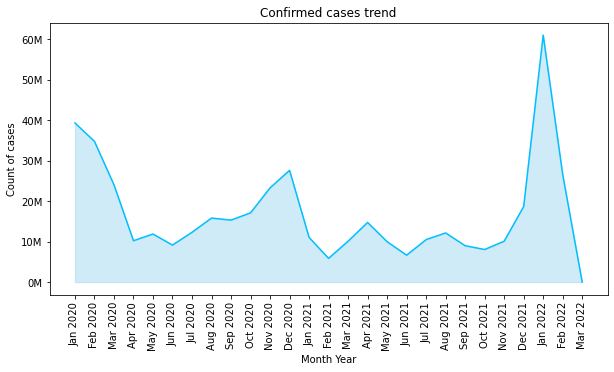

In [28]:
plot_line_graph(global_table.columns, global_table.loc['confirmed'].values.tolist(),'Confirmed cases trend', 'Month Year', 'Count of cases', color='deepskyblue', fillcolor='skyblue', scale = "M")

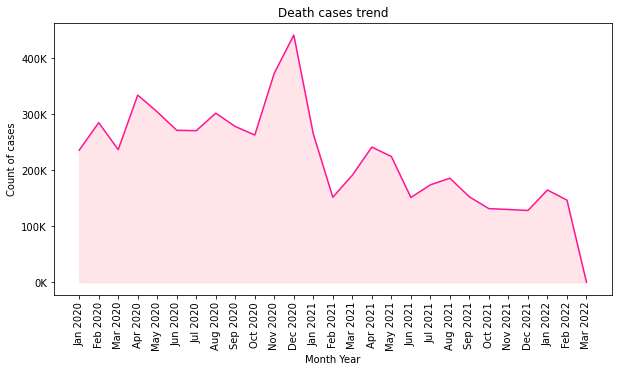

In [29]:
plot_line_graph(global_table.columns, global_table.loc['deaths'].values.tolist(),'Death cases trend', 'Month Year', 'Count of cases', color='deeppink', fillcolor='pink', scale = 'K')

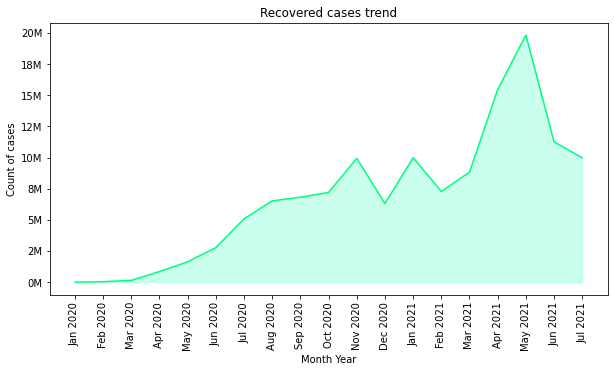

In [83]:
plot_line_graph(global_table.columns, global_table.loc['recoveries'].values.tolist(),'Recovered cases trend', 'Month Year', 'Count of cases', color='springgreen', fillcolor='aquamarine', scale = 'M')


### Obtaining country wise summary figures

In [110]:
country_wise_total_df = pd.DataFrame(columns=['confirmed'])
# country_wise_total_df['rec'] = recovered_monthly['tilldate']
country_wise_total_df['confirmed'] = confirmed_monthly['tilldate']
country_wise_total_df = country_wise_total_df.join(pd.DataFrame(deaths_monthly['tilldate']))
country_wise_total_df = country_wise_total_df.rename(columns={"tilldate":"deaths"})
# country_wise_total_df = country_wise_total_df.join(pd.DataFrame(recovered_monthly['tilldate']))
# country_wise_total_df = country_wise_total_df.rename(columns={"tilldate":"recoveries"})
country_wise_total_df = country_wise_total_df.drop('global')
country_wise_total_df = country_wise_total_df.drop('Winter Olympics 2022')
country_wise_total_df = country_wise_total_df.drop('Summer Olympics 2020')
country_wise_total_df.head(),country_wise_total_df.shape

(                confirmed  deaths
 Country/Region                   
 Afghanistan      176039.0  7641.0
 Albania          272621.0  3485.0
 Algeria          265410.0  6862.0
 Andorra           38794.0   152.0
 Angola            98909.0  1900.0,
 (196, 2))

#### Plotting top 5 most affected countries

In [109]:
confirmed_monthly.shape

(199, 28)

In [117]:
top_affected_countries = country_wise_total_df['confirmed'].sort_values(ascending = False).head(10)

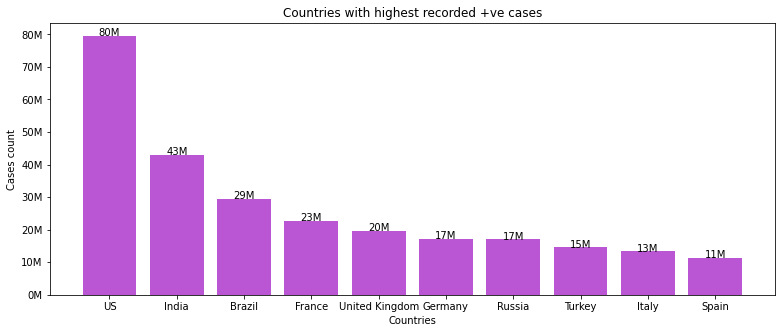

In [118]:
plot_bar_graph(top_affected_countries.index, top_affected_countries.values.tolist(), 'Countries with highest recorded +ve cases', 'Countries', 'Cases count', color='mediumorchid', width=0.8, scale = 'M',figsize=(13,5), orient = 'v')

#### Plotting top 5 least affected countries

In [119]:
least_affected_countries = country_wise_total_df['confirmed'].sort_values(ascending = True).head(10)

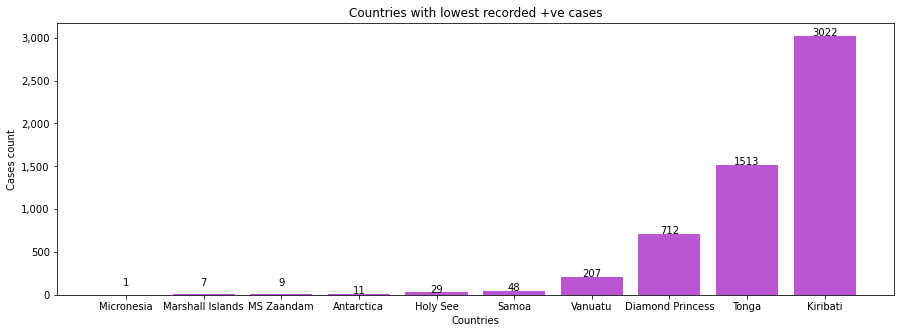

In [120]:
plot_bar_graph(least_affected_countries.index, least_affected_countries.values.tolist(), 'Countries with lowest recorded +ve cases', 'Countries', 'Cases count', color='mediumorchid', rotation=0, width=0.8, figsize=(15,5), orient = 'v')

#### Plotting top 5 countries with most casualities

In [121]:
top_deaths_countries = country_wise_total_df['deaths'].sort_values(ascending = False).head(10)

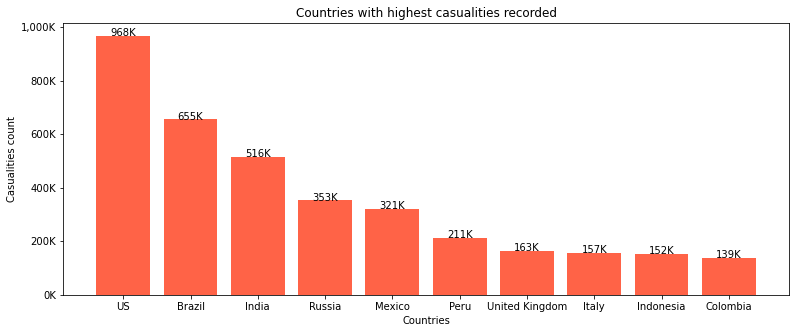

In [122]:
plot_bar_graph(top_deaths_countries.index, top_deaths_countries.values.tolist(), 'Countries with highest casualities recorded', 'Countries', 'Casualities count', color='tomato', orient='v', scale = 'K', width=0.8, figsize=(13,5))

#### Plotting top 5 least affected countries

In [123]:
least_deaths_countries = country_wise_total_df['deaths'].sort_values(ascending = True).head(10)

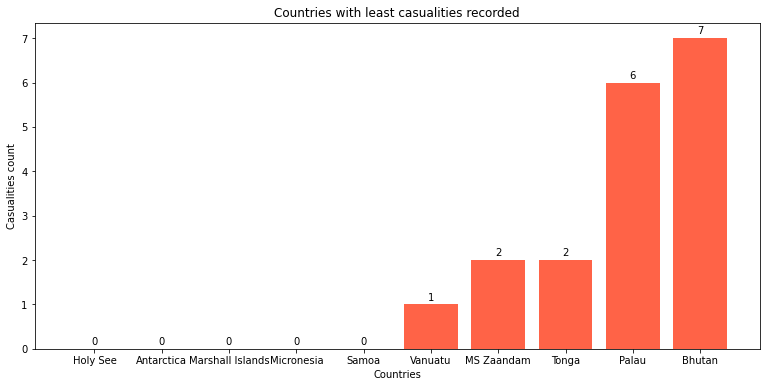

In [124]:
plot_bar_graph(least_deaths_countries.index, least_deaths_countries.values.tolist(), 'Countries with least casualities recorded', 'Countries', 'Casualities count', color='tomato', orient='v', width=0.8, figsize=(13,6), label_pushup_mag =0.1)

#### Checking the contribution of top countries in the entire worlds cases


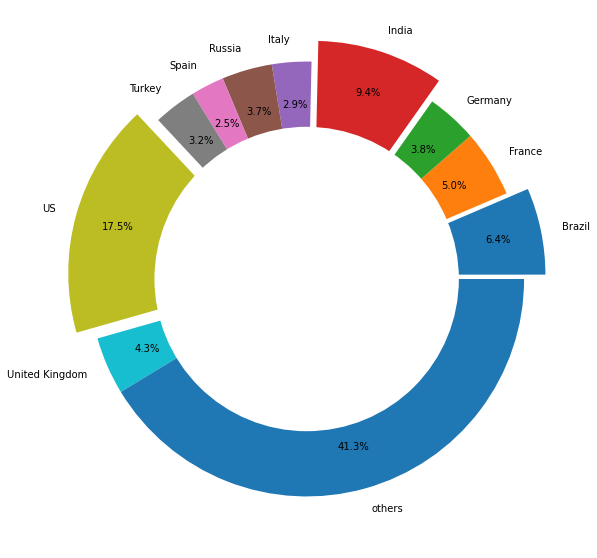

In [183]:
confirmed_cases = country_wise_total_df['confirmed']
compressed_conf = confirmed_cases[confirmed_cases<np.percentile(confirmed_cases, 95)].sum()
non_compressed_conf = confirmed_cases[confirmed_cases>=np.percentile(confirmed_cases, 95)]
non_compressed_conf['others'] = compressed_conf
non_compressed_conf

explode_list = [0.1 if (non_compressed_conf[i]/non_compressed_conf.sum())*100 > 5 else 0 for i in range(0,len(non_compressed_conf)-1)]
explode_list.append(0)
plt.figure(figsize=(10,10))
plt.pie(x = non_compressed_conf, labels = non_compressed_conf.index,autopct='%1.1f%%', explode=explode_list,pctdistance=0.80)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

#### plotting world map with cases count till date

In [187]:
import pandas as pd
import plotly.graph_objects as go

wm_df = confirmed_df.rename(columns= {"Country/Region" : "Country", "Province/State": "Province"})

In [188]:
wm_df['text'] = wm_df['Country'] + " " + wm_df["3/12/2022"].astype(str)

In [190]:
fig = go.Figure(data = go.Scattergeo(
    lon = wm_df["Long"],
    lat = wm_df["Lat"],
    text = wm_df["text"],
    mode = "markers",
    marker = dict(
        size = 12,
        opacity = 0.8,
        reversescale = True,
        autocolorscale = True,
        symbol = 'circle',
        line = dict(
            width = 1,
            color = 'rgba(102, 102, 102)'
        ),
        cmin = 0,
        color = wm_df['3/12/2022'],
        cmax = wm_df['3/12/2022'].max(),
        colorbar_title = "COVID 19 Reported Cases"
    )
))

In [194]:
fig.update_layout(
    title = "COVID19 Confirmed Cases Around the World",
    geo = dict(
        scope = "world",
        showland = True,
    )
)
# fig.show(renderer='png')
fig.write_html('world_map_dist.html', auto_open=True)